# Climate Change Tweet Classification

## Introduction

### Problem statement 

We are tasked to create a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their tweets.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Data Collection

In [2]:
Trainingdata = pd.read_csv("train.csv").fillna(' ')
Testdata = pd.read_csv("test_with_no_labels.csv").fillna(' ')

In [3]:
Trainingdata.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [4]:
Testdata.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


## Data Cleaning

In [5]:
train_df = Trainingdata.copy()
test_df = Testdata.copy()

print('Dataset size:',train_df.shape)
print('Columns:',train_df.columns)

Dataset size: (15819, 3)
Columns: Index(['sentiment', 'message', 'tweetid'], dtype='object')


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


<AxesSubplot:xlabel='sentiment', ylabel='count'>

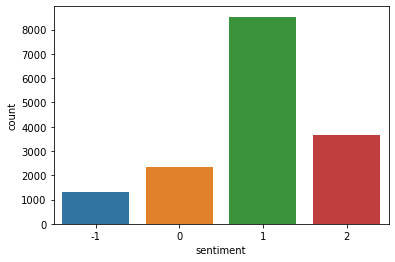

In [7]:
sns.countplot(x = 'sentiment', data = train_df)

Remove duplicate tweets

In [8]:
train_df = Trainingdata.drop_duplicates()
train_df.shape

(15819, 3)

In [9]:
train_df.tweetid.unique

<bound method Series.unique of 0        625221
1        126103
2        698562
3        573736
4        466954
          ...  
15814     22001
15815     17856
15816    384248
15817    819732
15818    806319
Name: tweetid, Length: 15819, dtype: int64>

Removing emojis

In [10]:
import emoji
import string

def remove_emoji(tweet_):
    characters = [str for str in tweet_]
    list_of_emoji = [i for i in characters if i in emoji.UNICODE_EMOJI]
    clean_tweet = ' '.join([str for str in tweet_.split() if not any(j in str for j in list_of_emoji)])
    return clean_tweet

In [11]:
tweets_list = []

for index, rows in train_df['message'].iteritems():
    rows =  remove_emoji(rows)
    tweets_list.append(rows)
    
train_df['message'] = tweets_list

Remove Line breaks, URL's, Numbers, Capital letters, & Punctuation

In [12]:
import re
import string


def tweet_preprocessor(tweet):
    tweet = tweet.replace('\n', ' ')                           # remove line breaks
    tweet = re.sub(r"\bhttps://t.co/\w+", '', tweet)           # remove URL's
    tweet = re.sub('\w*\d\w*', ' ', tweet)                     # remove numbers
    tweet = re.sub('[%s]' % re.escape(string.punctuation), ' ',   
            tweet.lower())                                     # remove capital letters and punctuation
    return tweet

In [13]:
for i,row in train_df.iterrows():
    train_df.at[i,'message'] = tweet_preprocessor(row['message'])

In [14]:
train_df

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesn t think carbon di...,625221
1,1,it s not like we lack evidence of anthropogeni...,126103
2,2,rt rawstory researchers say we have three ye...,698562
3,1,todayinmaker wired was a pivotal year in...,573736
4,1,rt soynoviodetodas it s and a racist sex...,466954
...,...,...,...
15814,1,rt ezlusztig they took down the material on ...,22001
15815,2,rt washingtonpost how climate change could b...,17856
15816,0,notiven rt nytimesworld what does trump act...,384248
15817,-1,rt hey liberals the climate change crap is...,819732


In [15]:
#Tokenization -> chops each tweet into a collection of individual words (i.e. tokens)
#Lemmatization -> Aims to cut each word down to its base form 
                #(e.g. laugh, laughs, laughing, laughed would be reduced to laugh)
                #This reduces the complexity of analysis by reducing number of unique words

##  Exploratory Data Analysis

## Model Building

In [39]:
# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# NLP Libraries
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
import string
import pickle

Data preprocessing

In [17]:
def data_preprocessing(df):
    lemm = WordNetLemmatizer()
    Tokenized_Doc=[]
    stopWords = set(stopwords.words('english'))
    
    for tweet in df['message']:
        
        onlyWords = re.sub('[^a-zA-Z]', ' ', tweet)     #keeping only words
        url = re.compile(r'https?://\S+|www\.\S+')      #removing URLs
        review_ = url.sub(r'',onlyWords)
        html=re.compile(r'<.*?>')
        review_ = html.sub(r'',review_)
        emojis = re.compile("["
                           u"\U0001F600-\U0001F64F"     # emoticons
                           u"\U0001F300-\U0001F5FF"     # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"     # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"     # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        
        review_ = emojis.sub(r'',review_)
        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(review_)
        gen_tweets = [lemm.lemmatize(token) for token in tokens if not token in stopWords]
        Tokenized_Doc.append(gen_tweets)
        df['tweet tokens'] = pd.Series(Tokenized_Doc)
        
    return df

In [18]:
# Preprocessing the data
train_df = data_preprocessing(train_df)
test_df = data_preprocessing(test_df)

In [20]:
train_df

,sentiment,message,tweetid,tweet tokens
0,1,polyscimajor epa chief doesn t think carbon di...,625221,"[polyscimajor, epa, chief, think, carbon, diox..."
1,1,it s not like we lack evidence of anthropogeni...,126103,"[like, lack, evidence, anthropogenic, global, ..."
2,2,rt rawstory researchers say we have three ye...,698562,"[rt, rawstory, researcher, say, three, year, a..."
3,1,todayinmaker wired was a pivotal year in...,573736,"[todayinmaker, wired, pivotal, year, war, clim..."
4,1,rt soynoviodetodas it s and a racist sex...,466954,"[rt, soynoviodetodas, racist, sexist, climate,..."
...,...,...,...,...
15814,1,rt ezlusztig they took down the material on ...,22001,"[rt, ezlusztig, took, material, global, warmin..."
15815,2,rt washingtonpost how climate change could b...,17856,"[rt, washingtonpost, climate, change, could, b..."
15816,0,notiven rt nytimesworld what does trump act...,384248,"[notiven, rt, nytimesworld, trump, actually, b..."
15817,-1,rt hey liberals the climate change crap is...,819732,"[rt, hey, liberal, climate, change, crap, hoax..."


In [21]:
#features and the label
X = train_df['tweet tokens']
y = train_df['sentiment']

In [22]:
# Tranforming the dataset
data = train_df['tweet tokens']
corpus = [' '.join(i) for i in data] #create your corpus here
vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
X = vectorizer.fit_transform(corpus)

In [23]:
X

<15819x19889 sparse matrix of type '<class 'numpy.float64'>'
	with 175274 stored elements in Compressed Sparse Row format>

# Logistic Regression -------------------------------------------------------------------------------

In [24]:
# Spliting the datasets and training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scikit_log_reg = LogisticRegression(solver='liblinear',random_state=42)
LogisticRegression_model=scikit_log_reg.fit(X_train, y_train)

In [25]:
# Predictions
y_pred = LogisticRegression_model.predict(X_test)

In [26]:
# Evaluating the Logistic Regression model performance
from sklearn import metrics
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

[[  75   29  165    9]
 [   4  121  276   24]
 [   7   36 1619   93]
 [   3   13  216  474]]
              precision    recall  f1-score   support

          -1       0.84      0.27      0.41       278
           0       0.61      0.28      0.39       425
           1       0.71      0.92      0.80      1755
           2       0.79      0.67      0.73       706

    accuracy                           0.72      3164
   macro avg       0.74      0.54      0.58      3164
weighted avg       0.73      0.72      0.70      3164



In [27]:
# Predicting on the test.csv
test_ = test_df['tweet tokens']
corpus = [' '.join(i) for i in test_]
tests_X = vectorizer.transform(corpus)

In [30]:
pred = LogisticRegression_model.predict(tests_X)
predictions = pred[:]

In [31]:
len(list(predictions))

10546

In [32]:
len(test_df['tweetid'].to_list())

10546

In [33]:
#creating kaggle submission
submission = pd.DataFrame(
    {'tweetid': test_df['tweetid'].to_list(),
     'sentiment': list(predictions)
    })
submission.to_csv("LogisticRegressionSubmissions.csv", index=False)

In [34]:
#saving model as dump
with open('logisticRegression.pkl', 'wb') as file:
    pickle.dump(LogisticRegression_model,file)

# DecisionTreeClassifier-----------------------------------------------------------------------------

In [40]:
# Spliting the datasets and training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = DecisionTreeClassifier()
decisionTree_model = clf.fit(X_train,y_train)

In [41]:
# Predictions
y_pred = decisionTree_model.predict(X_test)

In [42]:
# Evaluating the model performance
from sklearn import metrics
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

[[  80   44  134   20]
 [  23  137  230   35]
 [  61  171 1309  214]
 [  11   43  220  432]]
              precision    recall  f1-score   support

          -1       0.46      0.29      0.35       278
           0       0.35      0.32      0.33       425
           1       0.69      0.75      0.72      1755
           2       0.62      0.61      0.61       706

    accuracy                           0.62      3164
   macro avg       0.53      0.49      0.50      3164
weighted avg       0.61      0.62      0.61      3164



In [43]:
# Predicting on the test.csv
test_ = test_df['tweet tokens']
corpus = [' '.join(i) for i in test_]
tests_X = vectorizer.transform(corpus)

In [44]:
pred = decisionTree_model.predict(tests_X)
predictions_DT = pred[:]

In [45]:
#creating kaggle submission
submission = pd.DataFrame(
    {'tweetid': test_df['tweetid'].to_list(),
     'sentiment': list(predictions_DT)
    })
submission.to_csv("DecisionTreeClassifierSubmission.csv", index=False)

In [46]:
#saving model as dump
with open('DecisionTreeClassifier.pkl', 'wb') as file:
    pickle.dump(decisionTree_model,file)

# SVM Classifier----------------------------------------------------------------------------------------

In [47]:
# Spliting the datasets and training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = svm.SVC(kernel='linear') # Linear Kernel
SVM_model = clf.fit(X_train, y_train)

In [48]:
# Predictions
y_pred = SVM_model.predict(X_test)

In [49]:
# Evaluating the model performance
from sklearn import metrics
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

[[ 115   33  125    5]
 [   9  166  232   18]
 [  16   68 1557  114]
 [   6   21  172  507]]
              precision    recall  f1-score   support

          -1       0.79      0.41      0.54       278
           0       0.58      0.39      0.47       425
           1       0.75      0.89      0.81      1755
           2       0.79      0.72      0.75       706

    accuracy                           0.74      3164
   macro avg       0.72      0.60      0.64      3164
weighted avg       0.74      0.74      0.73      3164



In [50]:
# Predicting on the test.csv
test_ = test_df['tweet tokens']
corpus = [' '.join(i) for i in test_]
tests_X = vectorizer.transform(corpus)

In [51]:
pred = SVM_model.predict(tests_X)
predictions_SVM = pred[:]

In [53]:
#creating kaggle submission
submission = pd.DataFrame(
    {'tweetid': test_df['tweetid'].to_list(),
     'sentiment': list(predictions_SVM)
    })
submission.to_csv("LinearSVM_Submission.csv", index=False)

In [54]:
# Predicting on the test.csv
test_ = test_df['tweet tokens']
corpus = [' '.join(i) for i in test_]
tests_X = vectorizer.transform(corpus)#saving model as dump
with open('LinearSVM.pkl', 'wb') as file:
    pickle.dump(SVM_model,file)

# GaussianNB----------------------------------------------------------------------------------------

In [56]:
# Spliting the datasets and training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = GaussianNB()
X_train = X_train.todense()
GaussianNB_model = model.fit(X_train, y_train)

In [58]:
# Predictions
X_test = X_test.todense()
y_pred = GaussianNB_model.predict(X_test)

In [59]:
# Evaluating the model performance
from sklearn import metrics
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

[[136  36  89  17]
 [102 120 129  74]
 [234 230 949 342]
 [ 84  29 136 457]]
              precision    recall  f1-score   support

          -1       0.24      0.49      0.33       278
           0       0.29      0.28      0.29       425
           1       0.73      0.54      0.62      1755
           2       0.51      0.65      0.57       706

    accuracy                           0.53      3164
   macro avg       0.44      0.49      0.45      3164
weighted avg       0.58      0.53      0.54      3164



In [60]:
# Predicting on the test.csv
test_ = test_df['tweet tokens']
corpus = [' '.join(i) for i in test_]
tests_X = vectorizer.transform(corpus)

In [62]:
tests_X = tests_X.todense()
pred = GaussianNB_model.predict(tests_X)
predictions_GaussianNB = pred[:]

In [63]:
#creating kaggle submission
submission = pd.DataFrame(
    {'tweetid': test_df['tweetid'].to_list(),
     'sentiment': list(predictions_GaussianNB)
    })
submission.to_csv("GaussianNB_Submission.csv", index=False)

In [64]:
#saving model as dump
with open('GaussianNB.pkl', 'wb') as file:
    pickle.dump(SVM_model,file)

# MultinomialNB----------------------------------------------------------------------------------------

## Model Deployment